# 2D Localization with a Recurrent Neural Network
*Maxwell Pollack*

An agent accelerates randomly on a square of side length $l$ with inelastic boundaries. With $x^i_0 \sim \mathcal{U}(0,l)$, $v^i_0 = 0$, and $\Delta t=1$,

$$
\begin{split}
a^i_{\text{self},t} & \sim \mathcal{N}(0,\sigma^2) \\
v^i_t & = v^i_{t-1} + a^i_{\text{self},t} \\
x^i_t & = max\big( 0, min(l, x^i_{t-1} + v^i_t) \big) \\
a^i_{\text{env},t} & = -v_t^i \big( H(x^i_{t-1} + v^i_t - l) + H(-x^i_{t-1}-v^i_t) \big)\\
v^i_t & = v^i_t + a^i_{\text{env},t}
\end{split}$$

is computed for each time step $t = \{1,...,T-1\}$ and dimension $i=\{1,2\}$, where $H$ is the Heaviside step function.

In [82]:
import torch

def simulate(batches=1, T=256, l=16, d=2, sigma=0.3):

    input = torch.zeros(batches,T,2*d)
    x = torch.rand(batches,T,d)*(l-1)
    v = torch.zeros(batches,T,d)
    
    for t in range(1,T):
        
        input[:,t,:d] = sigma**2 * torch.randn(batches,1,d)
        v[:,t] = v[:,t-1] + input[:,t,:d]
        x[:,t] = torch.clamp(x[:,t-1] + v[:,t], 0, l-1)
        input[:,t,d:] = torch.where((x[:,t-1]+v[:,t] > l-1) | (x[:,t-1]+v[:,t] < 0), -v[:,t], torch.zeros(1))
        v[:,t] += input[:,t,d:]

    places = torch.flatten(torch.stack(torch.meshgrid(d*[torch.arange(float(l))]), dim=-1), end_dim=-2)
    target = torch.prod(torch.relu(1 - abs(x.unsqueeze(2) - places.expand(1,T,-1,-1))), dim=-1)
    
    return (input, target, x, v)

## Network

The components $a^i_{\text{self},t}$ and $a^i_{\text{env},t}$ are inputs to an [Elman RNN](https://en.wikipedia.org/wiki/Recurrent_neural_network#Elman_networks_and_Jordan_networks) with ReLU nonlinearities, trained with [Adam](https://arxiv.org/abs/1412.6980) to minimize the mean squared error between its output and the set of target activations

$$z^n_{\text{target},t} = max\big(0, 1-|x^0_t-n//l|\big) * max\big(0, 1-|x^1_t-n\%l|\big) \text{,}$$

where $n=\{0,...,l^2-1\}$ is the output neuron index. This models a unit-spaced $l \times l$ grid of [place cells](https://en.wikipedia.org/wiki/Place_cell) with a "bump" of activity tracking the agent's location in the environment. **Thus, the RNN is tasked with inferring the agent's location from its self-caused and environmentally-caused acceleration.**

In [ ]:
class Network(torch.nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(Network, self).__init__()
        self.rnn = torch.nn.RNN(n_input, n_hidden, batch_first=True, nonlinearity='relu')
        self.linear = torch.nn.Linear(n_hidden, n_output)

    def forward(self, input):
        hidden = self.rnn(input)[0]
        return (torch.relu(self.linear(hidden)), hidden)

network = Network(n_input=2*2, n_hidden=16**2, n_output=16**2)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)

for _ in range(10**6):
    
    input, target, x, v = simulate()
    output, hidden = network(input)

    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

## Behavior

The activity of the network over the course of a simulation is visualized in the movie below. The hidden cells are plotted on a 2D grid sorted by their input weights from $\vec a_\text{self}$ — this illustrates how the network integrates acceleration across time steps to track the agents **velocity** as a latent variable.

The network learns to update its location estimate (the "bump" of activity in its output) in an approximately Bayesian fashion. Each collision with a boundary collapses the normal component of the activity bump to the boundary coordinate, which then slowly widens as path integration errors reaccumulate. The network also narrows the activity bump by inferring the places it could **not** be during path integration (e.g. if the agent moves 5 units to the right and doesn't encounter a boundary, it could not possibly have started less than 5 units from the right boundary).

In [92]:
%matplotlib inline
from matplotlib import animation, pyplot as plt
from matplotlib.patches import ConnectionPatch, Circle

input, target, x, v = simulate(T=10**6)
output, hidden = network(input)

l = int(hidden.shape[-1]**0.5)

# Iteratively sort hidden cells row-wise by a_self^0 weights and column-wise by a_self^1 weights.
Win = next(network.parameters())
h_sorted = torch.argsort(Win[:,1]).view(l,l)
for _ in range(128):
    h_sorted = h_sorted.gather(0, torch.argsort(Win[h_sorted,0], dim=0))
    h_sorted = h_sorted.gather(1, torch.argsort(Win[h_sorted,1]))

hidden = hidden[...,h_sorted.flatten()]
    
fig,ax = plt.subplots(1,3, figsize=(13,7), gridspec_kw={'width_ratios':[1,l,l]})
plt.close()

plt.rcParams['font.size'] = 15

frames = [[ax[0].imshow(input[0,t].view(4,1).data.numpy(), vmin=0, vmax=0.5),
           ax[0].annotate(r'$\vec a_{self}$', (-0.25,0.75), xytext=(-3,0.75),
                          xycoords='axes fraction', va='center', annotation_clip=False,
                          arrowprops=dict(arrowstyle='-[')),
           ax[0].annotate(r'$\vec a_{env}$', (-0.25,0.25), xytext=(-3,0.25),
                          xycoords='axes fraction', va='center', annotation_clip=False,
                          arrowprops=dict(arrowstyle='-[')),
           ax[0].add_patch(ConnectionPatch((1,0.5),(0,0.5),'axes fraction',
                                           mutation_scale=20, axesA=ax[0],
                                           axesB=ax[1], arrowstyle='->')),
           ax[0].set_title('Input'),
           ax[1].imshow(hidden[0,t].view(l,l).data.numpy().T, vmin=0, vmax=0.5),
           ax[1].add_patch(ConnectionPatch((0.55,0),(0.45,0),'axes fraction',
                                           mutation_scale=20, arrowstyle='->',
                                           connectionstyle='arc, angleA=-90, angleB=-90,'+
                                           'rad=15, armA=20, armB=20')),
           ax[1].add_patch(ConnectionPatch((1,0.5),(0,0.5),'axes fraction', mutation_scale=20,
                                           axesA=ax[1], axesB=ax[2], arrowstyle='->')),
           ax[1].set_title('Hidden'),
           ax[2].imshow(output[0,t].view(l,l).data.numpy().T, vmin=0, vmax=0.5),
           ax[2].add_patch(Circle(x[0,t], radius=0.5, facecolor='r', edgecolor=None)),
           ax[2].set_title('Output')]
          
          for t in range(512)]

for axis in ax:
    axis.axis('off')

plt.rcParams['animation.html'] = 'html5'
animation.ArtistAnimation(fig, frames, interval=100)

## Receptive Fields of Hidden cells

The mean activation of each hidden cell at each location in the environment is plotted, using the same sorted arrangement of hidden cells as the above movie.

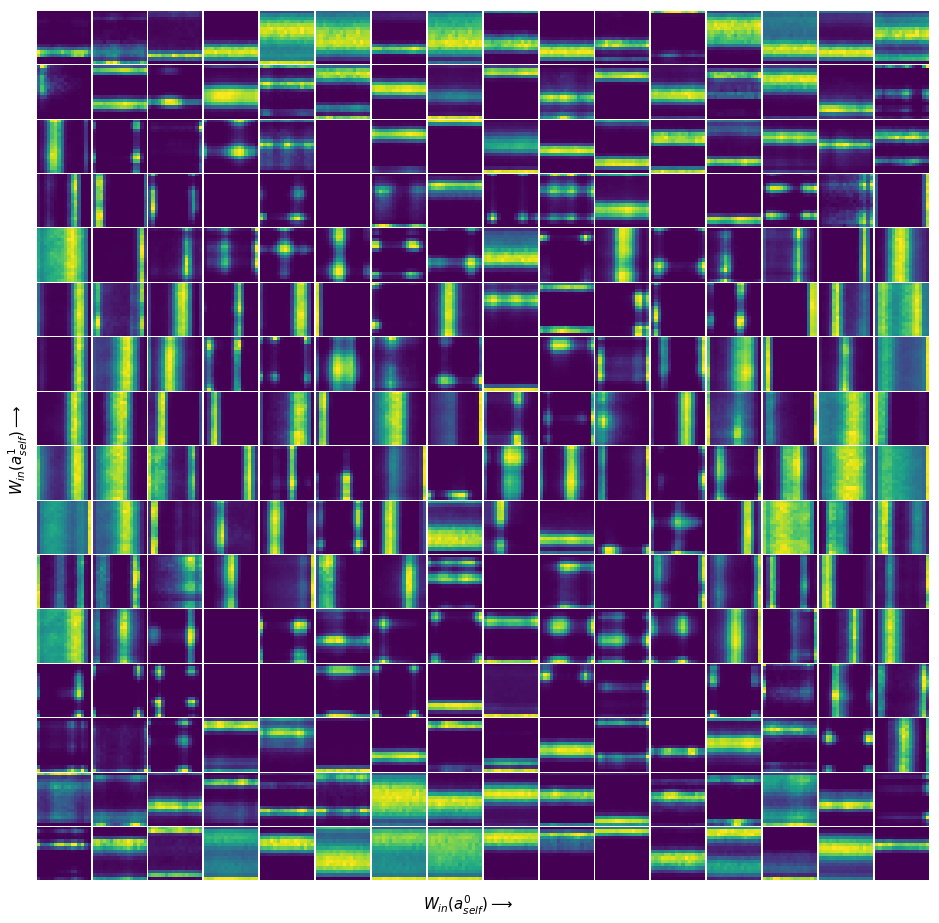

In [121]:
from scipy.stats import binned_statistic_2d

fig2,ax2 = plt.subplots(l, l, figsize=(16,16), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.02, hspace=0.02)
fig2.text(0.5, 0.1, r'$W_{in} (a_{self}^0) \longrightarrow$', ha='center')
fig2.text(0.1, 0.5, r'$W_{in} (a_{self}^1) \longrightarrow$', va='center', rotation='vertical')

for cell in range(hidden.shape[-1]):
    zAvg = binned_statistic_2d(x[0,:,0].data.numpy(),
                               x[0,:,1].data.numpy(),
                               hidden[0,:,cell].data.numpy(),
                               bins=range(l+1))[0]
    ax2[cell//l,cell%l].imshow(zAvg, vmin=0)
    ax2[cell//l,cell%l].axis('off')